<a href="https://colab.research.google.com/github/jellyho/AI_Learning_jellyho/blob/main/Machine%20Learning/11_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 주택 데이터셋 불러오기

In [9]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/python-machine-learning-book-2nd-edition/master/code/ch10/housing.data.txt', header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## 산점도?

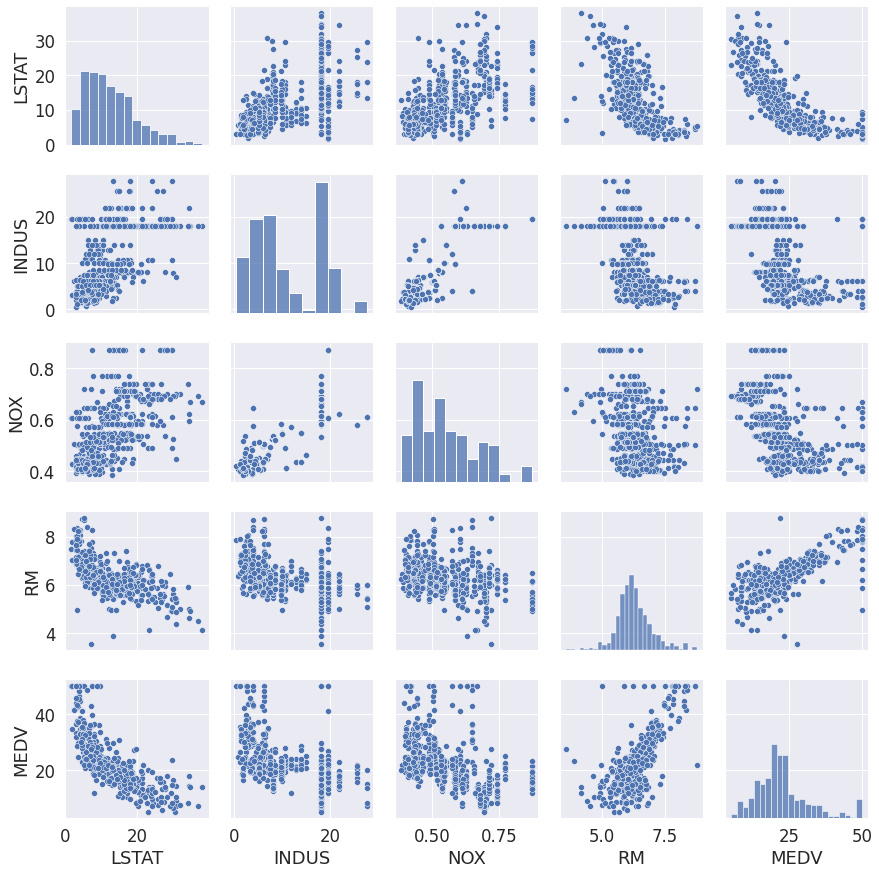

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], height=2.5)
plt.tight_layout()
plt.show()

특성간 관계를 잘 볼 수 있다. 특히 선형적으로 보이는 부분, 반비례 적 관계도 파악할 수 있다.

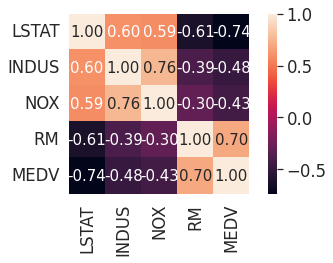

In [11]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols, xticklabels=cols)
plt.tight_layout()
plt.show()

수치가 높을 수록 두 특성의 상관관계가 높다. 비선형적으로 관계가 있는 변수도 있지만 선형적으로 관계가 있는 변수들도 있으며 이 변수관계는 선형 회귀 모델을 훈련하기에 적당하다.

In [21]:
class LRGD(object):

  def __init__(self, eta=0.001, n_iter=20):
    self.eta = eta
    self.n_iter = n_iter

  def fit(self, X, y):
    self.w_ = np.zeros(1 + X.shape[1])
    self.cost_ = []

    for i in range(self.n_iter):
      output = self.net_input(X)
      errors = (y - output)
      self.w_[1:] += self.eta * X.T.dot(errors)
      self.w_[0] += self.eta * errors.sum()
      cost = (errors**2).sum() / 2.0
      self.cost_.append(cost)
    return self

  def net_input(self, X):
    return np.dot(X, self.w_[1:]) + self.w_[0]
  
  def predict(self, X):
    return self.net_input(X)


In [22]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LRGD()
lr.fit(X_std, y_std)

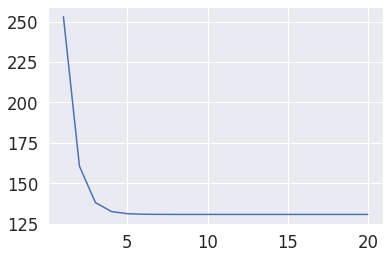

In [23]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.show()

In [24]:
def linplot(X, y, model):
  plt.scatter(X, y, edgecolor='white', s=70)
  plt.plot(X, model.predict(X), color='black', lw=2)
  return None

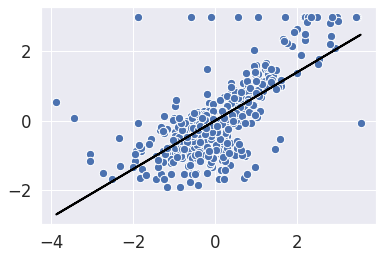

In [25]:
linplot(X_std, y_std, lr)

일반적으로 타깃 값은 표준화를 하지 않는다.

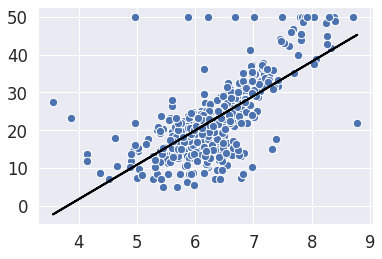

In [27]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
linplot(X, y, slr)
plt.show()

회귀 모델은 이상치에 영향을 민감하게 받을 수 밖에 없다. 그래서 이상치를 감지해야한다. RANSAC이라는 알고리즘은
1. 랜덤하게 일부 샘플을 정상치로 선택하여 모델 훈련
2. 훈련된 모델로 다른 샘플을 테스트, 일정 허용 오차 안에 속한 샘플은 정상치에 추가
3. 샘플이 추가된 정상치로 다시 모델 훈련
4. 훈련된 모델과 정상치 간의 오차 추정
5. 일정한 만족도를 얻으면 끝, 혹은 1~4의 지정된 반복 횟수가 지나면 끝

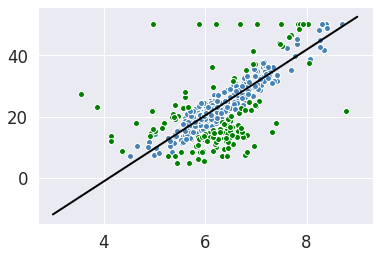

In [39]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), max_trials=100, min_samples=50, loss='absolute_loss', residual_threshold=5.0, random_state=0)
ransac.fit(X, y)
mask = ransac.inlier_mask_
notmask = np.logical_not(mask)
line_X = np.arange(3, 10, 1)
line_y = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[mask], y[mask], c='steelblue', edgecolor='white', marker='o', label='Inliers')
plt.scatter(X[notmask], y[notmask], c='green', edgecolor='white', marker='o', label='Outliers')
plt.plot(line_X, line_y, color='black', lw=2)
plt.show()